In [199]:
import numpy as np
from scipy.optimize import minimize

def sabr_volatility(F, K, T, alpha, beta, rho, nu):
    """
    Hagan (2002) SABR Implied Volatility Formula.
    """
    # Avoid division by zero for ATM
    if abs(F - K) < 1e-5:
        numer = alpha
        denom = F ** (1 - beta)
        term1 = 1 + ((1 - beta)**2 / 24) * (alpha**2) / (F**(2 - 2*beta))
        term2 = (rho * beta * alpha * nu / 4) * T
        term3 = (nu**2 * (2 - 3*rho**2) / 24) * T
        return (numer / denom) * (term1 + term2 + term3)

    # Standard Case
    FK = F * K
    logFK = np.log(F / K)
    z = (nu / alpha) * (FK**((1 - beta) / 2)) * logFK
    
    # Function x(z)
    # Guard against negative sqrt input if z is wild, though bounds help
    discriminant = 1 - 2*rho*z + z**2
    if discriminant <= 0: return 0.0 # Fail safe
    
    x_z = np.log((np.sqrt(discriminant) + z - rho) / (1 - rho))
    
    numer = alpha
    denom = (FK**((1 - beta) / 2)) * (1 + ((1 - beta)**2 / 24) * logFK**2 + ((1 - beta)**4 / 1920) * logFK**4)
    
    if abs(x_z) < 1e-5: # Avoid small divisor
        vol = (numer / denom)
    else:
        vol = (numer / denom) * (z / x_z)

    term1 = 1 + ((1 - beta)**2 / 24) * (alpha**2) / (FK**(1 - beta))
    term2 = (rho * beta * alpha * nu / 4) * T
    term3 = (nu**2 * (2 - 3*rho**2) / 24) * T
    
    return vol * (term1 + term2 + term3)

def calibrate_sabr(F, T, strikes, market_vols, beta=0.5):
    """
    Calibrates Alpha, Rho, Nu for a single expiry slice.
    Beta is fixed (standard practice).
    """
    # Initial Guesses: Alpha (ATM vol approx), Rho (0), Nu (0.5)
    atm_vol_est = np.mean(market_vols) 
    initial_guess = [atm_vol_est * (F**(1-beta)), 0.0, 0.5]
    
    # Bounds: Alpha > 0, -1 < Rho < 1, Nu > 0
    bounds = [(1e-5, None), (-0.999, 0.999), (1e-5, 5.0)]

    def error_func(params):
        alpha, rho, nu = params
        model_vols = np.array([sabr_volatility(F, K, T, alpha, beta, rho, nu) for K in strikes])
        # Weighted Squared Error (Give more weight to ATM/Liquid strikes if volume data existed)
        # Here we use standard MSE
        residuals = model_vols - market_vols
        return np.sum(residuals**2)

    try:
        result = minimize(error_func, initial_guess, bounds=bounds, method='L-BFGS-B')
        return {
            "alpha": result.x[0],
            "beta": beta,
            "rho": result.x[1],
            "nu": result.x[2],
            "error": result.fun,
            "success": result.success
        }
    except Exception as e:
        return None

In [200]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

def get_clean_surface_data(symbol, max_expiry_years=1.5):
    """
    Fetches option chain, cleans illiquid strikes, filters bad vols.
    Returns a dictionary keyed by expiry date.
    """
    ticker = yf.Ticker(symbol)
    try:
        spot = ticker.info.get('regularMarketPrice', None)
        if spot is None:
            # Fallback for indices if regularMarketPrice is missing
            hist = ticker.history(period="1d")
            spot = hist['Close'].iloc[-1]
    except:
        print(f"Error fetching spot for {symbol}")
        return {}, 0.0

    expiries = ticker.options
    today = datetime.now()
    
    valid_data = {}

    for date_str in expiries:
        # Calculate T (years)
        exp_date = datetime.strptime(date_str, "%Y-%m-%d")
        days_to_expiry = (exp_date - today).days
        T = days_to_expiry / 365.0
        
        # Filter: Ignore extremely short (noise) or long expiries
        if T < 7/365.0 or T > max_expiry_years:
            continue

        try:
            chain = ticker.option_chain(date_str)
            # Combine calls/puts or just use Puts for OTM low strikes and Calls for OTM high strikes (OOTM logic)
            # For simplicity and robustness, we often stick to OTM options:
            # Strikes < Spot -> Puts, Strikes > Spot -> Calls
            
            calls = chain.calls
            puts = chain.puts
            
            # Simple OTM blending
            calls['type'] = 'call'
            puts['type'] = 'put'
            
            # Filter criteria
            # 1. Volatility > 1% (remove 0s and placeholders like 1e-5)
            # 2. Open Interest > 0 (ensure some liquidity/validity)
            # 3. Bid/Ask spread check (optional, yfinance data is often delayed/last)
            
            calls = calls[(calls['impliedVolatility'] > 0.01) & (calls['strike'] > spot)]
            puts = puts[(puts['impliedVolatility'] > 0.01) & (puts['strike'] < spot)]
            
            # Combine into one DataFrame
            df_slice = pd.concat([puts, calls])
            
            if len(df_slice) < 5: # Need enough points to calibrate
                continue

            valid_data[date_str] = {
                "T": T,
                "strikes": df_slice['strike'].values,
                "vols": df_slice['impliedVolatility'].values,
                "df": df_slice
            }
            
        except Exception as e:
            print(f"Skipping {date_str}: {e}")
            continue
            
    return valid_data, spot

Fetching and cleaning data for ^SPX...
Spot Price: 6538.76
Found 41 valid expiries.
Calibrating SABR for each expiry...


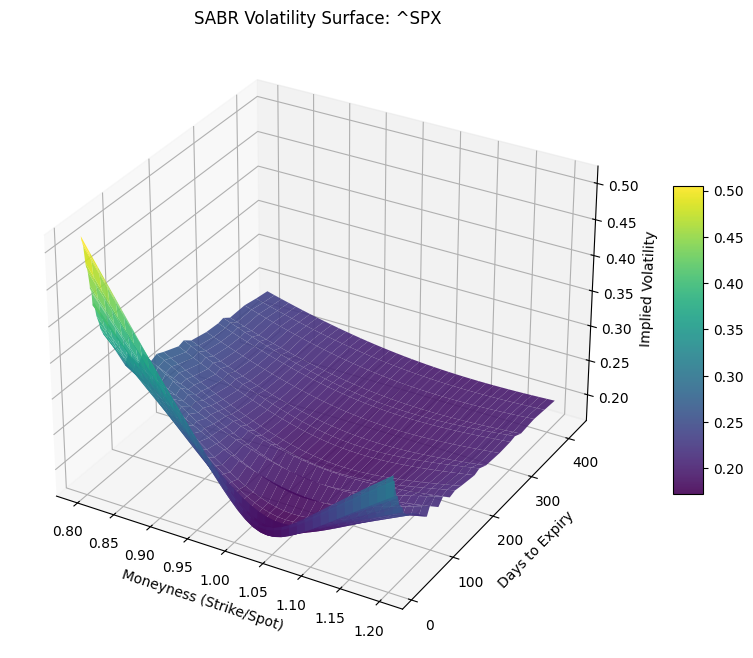

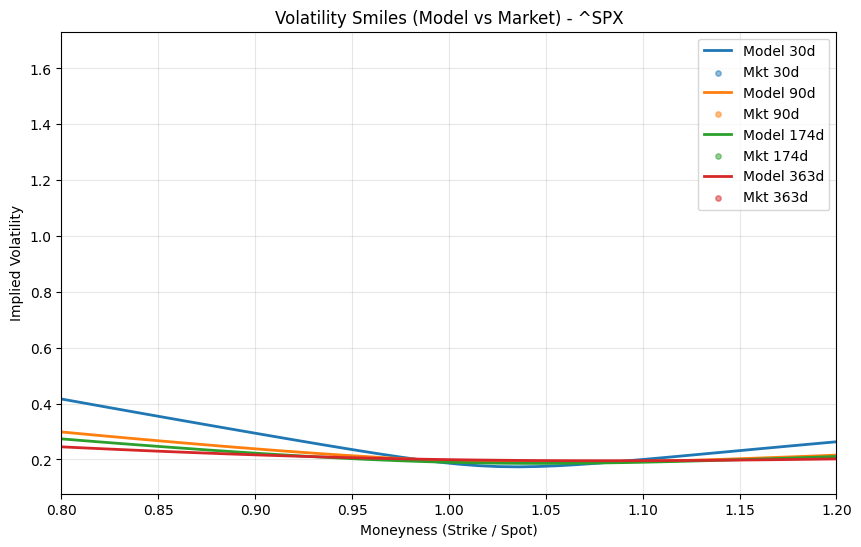

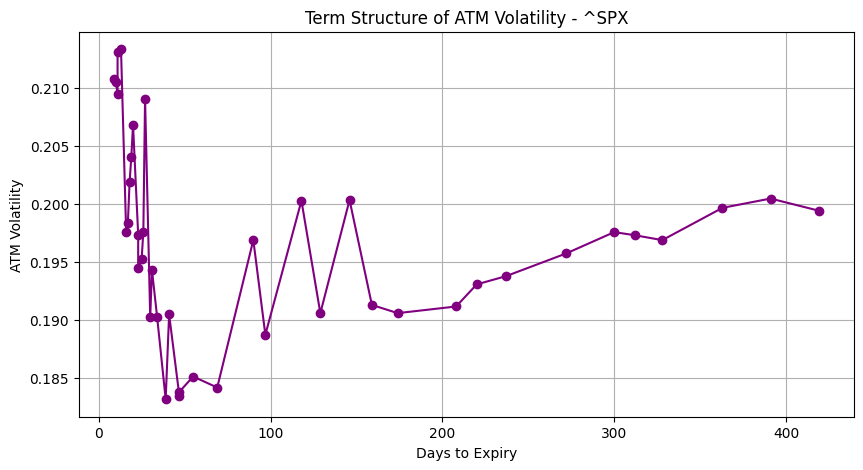

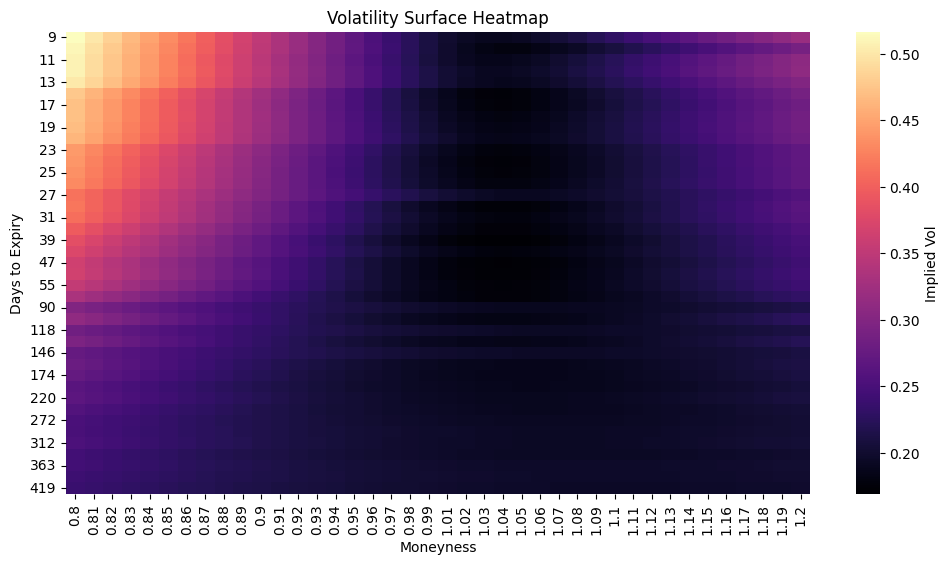

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# --- 1. CONFIGURATION ---
SYMBOL = "^SPX"
BETA = 0.5  # Standard for indices

# --- 2. FETCH DATA ---
print(f"Fetching and cleaning data for {SYMBOL}...")
expiry_data, spot = get_clean_surface_data(SYMBOL)

if not expiry_data:
    raise ValueError("No valid data found. Check ticker or internet connection.")

print(f"Spot Price: {spot:.2f}")
print(f"Found {len(expiry_data)} valid expiries.")

# --- 3. CALIBRATION & SURFACE GENERATION ---
calibrated_params = {}
surface_rows = []
all_moneyness = np.linspace(0.8, 1.2, 40) # Standardized Moneyness Grid (80% to 120% of Spot)

print("Calibrating SABR for each expiry...")

for date_str, data in expiry_data.items():
    T = data['T']
    strikes = data['strikes']
    mkt_vols = data['vols']
    
    # Calibrate
    res = calibrate_sabr(spot, T, strikes, mkt_vols, beta=BETA)
    
    if res and res['success']:
        calibrated_params[date_str] = res
        
        # Generate Surface Points for this slice
        # We use Moneyness (K/F) so plots are comparable across time
        grid_strikes = all_moneyness * spot
        
        model_vols = []
        for K in grid_strikes:
            vol = sabr_volatility(spot, K, T, res['alpha'], res['beta'], res['rho'], res['nu'])
            model_vols.append(vol)
            
        surface_rows.append({
            "ExpiryDate": date_str,
            "T": T,
            "Days": int(T*365),
            "Vols": model_vols
        })
    else:
        print(f"Calibration failed for {date_str}")

# Convert to plotting format
expiries_sorted = sorted(surface_rows, key=lambda x: x['T'])
X_moneyness, Y_days = np.meshgrid(all_moneyness, [row['Days'] for row in expiries_sorted])
Z_vols = np.array([row['Vols'] for row in expiries_sorted])

# --- 4. PROFESSIONAL PLOTS ---

# A. 3D Surface (Overview)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_moneyness, Y_days, Z_vols, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('Moneyness (Strike/Spot)')
ax.set_ylabel('Days to Expiry')
ax.set_zlabel('Implied Volatility')
ax.set_title(f'SABR Volatility Surface: {SYMBOL}')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

# B. Volatility Smile Slices (Detailed Analysis)
# Select ~4 key expiries to plot (e.g. near 1m, 3m, 6m, 1y)
target_days = [30, 90, 180, 365]
plt.figure(figsize=(10, 6))

for target in target_days:
    # Find closest available expiry
    closest_expiry = min(expiries_sorted, key=lambda x: abs(x['Days'] - target))
    
    # Plot Model
    plt.plot(all_moneyness, closest_expiry['Vols'], label=f"Model {closest_expiry['Days']}d", linewidth=2)
    
    # Overlay Market Data (Need to re-fetch raw data for scatter)
    raw_data = expiry_data[closest_expiry['ExpiryDate']]
    raw_moneyness = raw_data['strikes'] / spot
    plt.scatter(raw_moneyness, raw_data['vols'], s=15, alpha=0.5, label=f"Mkt {closest_expiry['Days']}d")

plt.xlabel("Moneyness (Strike / Spot)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smiles (Model vs Market) - {SYMBOL}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.8, 1.2)
plt.show()

# C. Term Structure (ATM Volatility)
# Moneyness = 1.0 is roughly index 20 in our linspace(0.8, 1.2, 40)
atm_index = np.abs(all_moneyness - 1.0).argmin()
atm_vols = Z_vols[:, atm_index]
days_axis = [row['Days'] for row in expiries_sorted]

plt.figure(figsize=(10, 5))
plt.plot(days_axis, atm_vols, marker='o', linestyle='-', color='purple')
plt.xlabel("Days to Expiry")
plt.ylabel("ATM Volatility")
plt.title(f"Term Structure of ATM Volatility - {SYMBOL}")
plt.grid(True)
plt.show()

# D. Heatmap (Quant View)
plt.figure(figsize=(12, 6))
df_heat = pd.DataFrame(Z_vols, index=days_axis, columns=np.round(all_moneyness, 2))
sns.heatmap(df_heat, cmap="magma", cbar_kws={'label': 'Implied Vol'})
plt.xlabel("Moneyness")
plt.ylabel("Days to Expiry")
plt.title("Volatility Surface Heatmap")
plt.show()